<a href="https://colab.research.google.com/github/ayyanar-03/machine-learning-projects/blob/main/proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from pathlib import Path

# Placeholder definitions for missing variables
FILE_PATH = "/content/ihdp_data.csv" # Using an available file from kernel state
OUT_DIR = Path("output")
OUT_DIR.mkdir(exist_ok=True)

# Dummy DataFrame for demonstration purposes
df = pd.DataFrame({
    'treatment': [0, 1, 0, 1, 0, 1],
    'outcome': [10, 12, 11, 13, 10, 14],
    'covariate1': [1, 2, 1, 2, 1, 2],
    'covariate2': [3, 4, 3, 4, 3, 4],
    'modifier1': [5, 6, 5, 6, 5, 6],
    'modifier2': [7, 8, 7, 8, 7, 8],
    'cate_cf': [1.5, 2.0, 1.8, 2.2, 1.7, 2.1],
    'cate_dr': [1.6, 2.1, 1.9, 2.3, 1.8, 2.2],
    'true_tau': [1.0, 2.0, 1.0, 2.0, 1.0, 2.0]
})

W_cols = ['covariate1', 'covariate2']
X_cols = ['modifier1', 'modifier2']
t_col = 'treatment'
y_col = 'outcome'
dag_str = "A -> B"
identified_estimand = "E[Y|do(T)]"
estimate_ate = "ATE = 1.5 (dummy value)"
refute_placebo = "Passed (dummy value)"
refute_random_common_cause = "Passed (dummy value)"
mse_cf = 0.25 # Dummy value
mse_dr = 0.20 # Dummy value
subgroup_report = pd.DataFrame({
    'Subgroup': ['Group A', 'Group B'],
    'Mean CATE (CausalForestDML)': [1.8, 2.1],
    'Mean CATE (DRLearner)': [1.9, 2.2]
})

# ---------- Generate a technical report template ----------
report_md = f"""
# Technical Report — Heterogeneous Treatment Effects (HTE) Analysis

**Dataset path:** `{FILE_PATH}`
**Rows:** {len(df)}, **Covariates used:** {W_cols}, **Effect modifiers used:** {X_cols}

---

## 1. Objective
Estimate heterogeneous treatment effects (CATE) of `{t_col}` on `{y_col}`, adjusting for confounders and analyzing heterogeneity across subgroups.

## 2. Data generation / loading
- If synthetic: generation process injects heterogeneity as `true_tau`.
- If uploaded: loaded from `{FILE_PATH}`. Check variables and data quality.

## 3. Causal assumptions and DAG
DAG used in this analysis:

```graphviz
{dag_str}
```

## 4. Identification
Identified estimand:
```
{identified_estimand}
```

## 5. Average Treatment Effect (ATE) Estimation (sanity check)
Baseline ATE estimate (linear regression):
```
{estimate_ate}
```

### Refutation Checks
- **Placebo Treatment Refuter:** {refute_placebo}
- **Random Common Cause Refuter:** {refute_random_common_cause}

## 6. Heterogeneous Treatment Effect (HTE) Estimation

### CausalForestDML
- **CATE (CausalForestDML) Summary:**
```
{df['cate_cf'].describe()}
```

### DRLearner
- **CATE (DRLearner) Summary:**
```
{df['cate_dr'].describe()}
```

### Performance vs. True Tau (if available)
"""
if "true_tau" in df.columns:
    report_md += f"""
- **MSE CausalForestDML vs true_tau:** {mse_cf:.4f}
- **MSE DRLearner vs true_tau:** {mse_dr:.4f}

"""
else:
    report_md += f"""
- No `true_tau` column available for comparison.

"""

report_md += f"""
## 7. Subgroup Analysis

Mean CATE estimates across subgroups based on effect modifiers:

```
{subgroup_report.to_markdown(index=False)}
```

## 8. Visualizations

- **Estimated CATE vs True CATE (if applicable):** See `true_vs_estimated_cate.png`
- **Distribution of CATE (CausalForestDML):** See `cate_cf_hist.png`
- **Distribution of CATE (DRLearner):** See `cate_dr_hist.png`

---
**Note:** This report provides a summary. Detailed results and plots are saved in the `{OUT_DIR}` directory.
"""

report_path = OUT_DIR / "technical_report.md"
report_path.write_text(report_md)
print(f"Technical report template saved to {report_path}")


Technical report template saved to output/technical_report.md


In [6]:
!pip install dowhy econml causal-learn graphviz pygraphviz
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (8,6)})

# Repro
SEED = 42
np.random.seed(SEED)

# --- Paths / output ---
DATA_PATH = "/content/ihdp_data.csv"   # path you supplied (kept verbatim per your instruction)
OUT_DIR = Path("./hte_pipeline_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# 1) Data load / synthetic fallback
# -------------------------
def generate_synthetic(n=20000, seed=SEED):
    np.random.seed(seed)
    Z1 = np.random.normal(0, 1, n)
    Z2 = np.random.binomial(1, 0.4, n)
    Z3 = np.random.normal(3, 2, n)
    M1 = np.random.normal(0, 1, n)
    M2 = np.random.binomial(1, 0.3, n)
    logits = 0.5 * Z1 - 1.0 * Z2 + 0.4 * Z3
    propensity = 1 / (1 + np.exp(-logits))
    T = np.random.binomial(1, propensity)
    tau = 2 + 1.5 * M1 + 3 * M2
    baseline = 1.5 * Z1 + 2.0 * Z2 + 0.3 * Z3 + 1.0 * M1 + 0.5 * M2
    noise = np.random.normal(0, 1, n)
    Y = baseline + T * tau + noise
    df = pd.DataFrame({
        "Treatment": T,
        "Outcome": Y,
        "Z1": Z1,
        "Z2": Z2,
        "Z3": Z3,
        "M1": M1,
        "M2": M2,
        "propensity": propensity,
        "true_tau": tau
    })
    return df

if os.path.exists(DATA_PATH):
    try:
        df = pd.read_csv(DATA_PATH)
        print(f"Loaded {DATA_PATH} → shape {df.shape}")
        if not (("Treatment" in df.columns) and ("Outcome" in df.columns)):
            print("Warning: uploaded file missing 'Treatment'/'Outcome' columns → using synthetic data instead.")
            df = generate_synthetic()
    except Exception as e:
        print("Error reading uploaded file:", e)
        df = generate_synthetic()
else:
    print("Uploaded file not found at path; generating synthetic data.")
    df = generate_synthetic()

# Normalize column names to common names when possible
col_map = {}
for c in df.columns:
    if c.lower() in ("treatment", "t"):
        col_map[c] = "Treatment"
    if c.lower() in ("outcome", "y"):
        col_map[c] = "Outcome"
df = df.rename(columns=col_map)

# Identify treatment/outcome/covariates/effect modifiers
T_col = "Treatment"
Y_col = "Outcome"
if T_col not in df.columns or Y_col not in df.columns:
    raise ValueError("Dataset must contain Treatment and Outcome columns (after normalization).")

exclude = {T_col, Y_col, "true_tau", "propensity"}
covariates = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
effect_modifiers = [c for c in covariates if c.lower().startswith("m")]
if len(effect_modifiers) == 0:
    # pick top-2 correlated with outcome as effect modifiers
    corrs = {c: abs(df[c].corr(df[Y_col])) for c in covariates}
    effect_modifiers = sorted(corrs, key=corrs.get, reverse=True)[:2]
print("Covariates:", covariates)
print("Effect modifiers:", effect_modifiers)

# -------------
# 2) DoWhy causal model, DAG, identification, refutation
# -------------
try:
    import dowhy
    from dowhy import CausalModel
    from dowhy.do_why import graphviz_to_png
except Exception as e:
    raise ImportError("dowhy not installed; pip install dowhy") from e

# Build a simple DAG (confounders -> Treatment and Outcome; modifiers -> Outcome & Treatment; T -> Y)
dag_edges = []
confounders = [c for c in covariates if c not in effect_modifiers]
for z in confounders:
    dag_edges.append(f"{z} -> {T_col}")
    dag_edges.append(f"{z} -> {Y_col}")
for m in effect_modifiers:
    dag_edges.append(f"{m} -> {Y_col}")
    dag_edges.append(f"{m} -> {T_col}")
dag_edges.append(f"{T_col} -> {Y_col}")
dag_str = "digraph G { " + " ; ".join(dag_edges) + " }"
print("DAG DOT:", dag_str)

model = CausalModel(data=df, treatment=T_col, outcome=Y_col, graph=dag_str)
# visualize DAG
try:
    graphviz_to_png(dag_str, str(OUT_DIR / "causal_graph.png"))
    print("Saved causal_graph.png")
except Exception:
    (OUT_DIR / "causal_graph.dot").write_text(dag_str)
    print("Saved causal_graph.dot (graphviz binary may be missing)")

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified estimand:", identified_estimand)

# Baseline ATE estimate (linear reg)
estimate_ate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print("ATE:", estimate_ate)

# Refutations
refute_placebo = model.refute_estimate(identified_estimand, estimate_ate, method_name="placebo_treatment_refuter", placebo_type="permute")
refute_rand = model.refute_estimate(identified_estimand, estimate_ate, method_name="random_common_cause")
print("Refute placebo:", refute_placebo)
print("Refute random common cause:", refute_rand)

# -------------
# 3) Prepare arrays for ML / EconML
# -------------
W_cols = covariates  # controls
X_cols = effect_modifiers  # heterogeneity conditioning features
W = df[W_cols] if len(W_cols) > 0 else None
X = df[X_cols] if len(X_cols) > 0 else None
T = df[T_col].values
Y = df[Y_col].values

# Standard preprocessing for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Train/test split for downstream ML models and for neural nets
train_idx, test_idx = train_test_split(np.arange(len(df)), test_size=0.2, random_state=SEED, stratify=df[T_col] if df[T_col].nunique()>1 else None)
X_train = df.iloc[train_idx][X_cols].values if len(X_cols)>0 else None
W_train = df.iloc[train_idx][W_cols].values if len(W_cols)>0 else None
T_train = df.iloc[train_idx][T_col].values
Y_train = df.iloc[train_idx][Y_col].values
X_test = df.iloc[test_idx][X_cols].values if len(X_cols)>0 else None
W_test = df.iloc[test_idx][W_cols].values if len(W_cols)>0 else None
T_test = df.iloc[test_idx][T_col].values
Y_test = df.iloc[test_idx][Y_col].values

scaler_W = StandardScaler()
if W_train is not None:
    W_train_scaled = scaler_W.fit_transform(W_train)
    W_test_scaled = scaler_W.transform(W_test)
else:
    W_train_scaled = None
    W_test_scaled = None

scaler_X = StandardScaler()
if X_train is not None:
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
else:
    X_train_scaled = None
    X_test_scaled = None

# --------------------------
# 4) EconML: CausalForestDML & DRLearner
# --------------------------
try:
    from econml.dml import CausalForestDML
    from econml.dr import DRLearner
except Exception as e:
    raise ImportError("EconML not installed; pip install econml") from e

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

n_jobs = -1
rf_y = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=SEED)
rf_t = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, random_state=SEED)

# Fit CausalForestDML
cf = CausalForestDML(model_y=rf_y, model_t=rf_t, discrete_treatment=True, cv=3, random_state=SEED, n_jobs=n_jobs)
print("Fitting CausalForestDML (this may take a while)...")
cf.fit(Y, T, X=X if X is not None else None, W=W if W is not None else None)
cate_cf = cf.effect(X=X if X is not None else None)
df["cate_cf"] = cate_cf
print("CausalForestDML done; cate_cf stats:")
print(df["cate_cf"].describe())

# Fit DRLearner
dr = DRLearner(model_regression=rf_y, model_propensity=rf_t, model_final=RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=SEED), cv=3, random_state=SEED)
print("Fitting DRLearner ...")
dr.fit(Y, T, X=X if X is not None else None, W=W if W is not None else None)
cate_dr = dr.effect(X=X if X is not None else None)
df["cate_dr"] = cate_dr
print("DRLearner done; cate_dr stats:")
print(df["cate_dr"].describe())

# --------------------------
# 5) PyTorch: TARNet and DragonNet
# --------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Utilities for datasets
def to_tensor(arr, dtype=torch.float32):
    return torch.tensor(arr, dtype=dtype)

# Build a feedforward MLP block
def mlp_block(input_dim, hidden_units=[200, 200], dropout=0.0):
    layers = []
    prev = input_dim
    for h in hidden_units:
        layers.append(nn.Linear(prev, h))
        layers.append(nn.ReLU())
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        prev = h
    return nn.Sequential(*layers)

# TARNet implementation (representation + 2 outcome heads)
class TARNet(nn.Module):
    def __init__(self, input_dim, rep_hidden=[200,200], head_hidden=[100,100]):
        super().__init__()
        self.representation = mlp_block(input_dim, rep_hidden)
        rep_out_dim = rep_hidden[-1] if len(rep_hidden)>0 else input_dim
        # two heads
        self.head0 = mlp_block(rep_out_dim, head_hidden)
        self.out0 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
        self.head1 = mlp_block(rep_out_dim, head_hidden)
        self.out1 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
    def forward(self, x):
        r = self.representation(x)
        h0 = self.head0(r)
        y0 = self.out0(h0).squeeze(-1)
        h1 = self.head1(r)
        y1 = self.out1(h1).squeeze(-1)
        return y0, y1

# DragonNet: representation + propensity head + outcome heads + targeted regularization
class DragonNet(nn.Module):
    def __init__(self, input_dim, rep_hidden=[200,200], head_hidden=[100,100], prop_hidden=[100]):
        super().__init__()
        self.representation = mlp_block(input_dim, rep_hidden)
        rep_out_dim = rep_hidden[-1] if len(rep_hidden)>0 else input_dim
        # propensity head
        self.prop_head = mlp_block(rep_out_dim, prop_hidden)
        self.prop_out = nn.Linear(prop_hidden[-1] if len(prop_hidden)>0 else rep_out_dim, 1)
        # outcome heads
        self.head0 = mlp_block(rep_out_dim, head_hidden)
        self.out0 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
        self.head1 = mlp_block(rep_out_dim, head_hidden)
        self.out1 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
    def forward(self, x):
        r = self.representation(x)
        p_h = self.prop_head(r)
        p = torch.sigmoid(self.prop_out(p_h)).squeeze(-1)
        h0 = self.head0(r)
        y0 = self.out0(h0).squeeze(-1)
        h1 = self.head1(r)
        y1 = self.out1(h1).squeeze(-1)
        return y0, y1, p

# Prepare input matrix for neural nets: we'll use W (controls) and X (modifiers) together as features
features_cols = W_cols[:]  # copy
# include X_cols (effect modifiers) if not included already
for c in X_cols:
    if c not in features_cols:
        features_cols.append(c)
features = df[features_cols].values
# standardize features
from sklearn.preprocessing import StandardScaler
feat_scaler = StandardScaler()
features_scaled = feat_scaler.fit_transform(features)
# split into train/test using previously computed indices
features_train = features_scaled[train_idx]
features_test = features_scaled[test_idx]
T_train_t = T_train.astype(np.float32)
Y_train_t = Y_train.astype(np.float32)
T_test_t = T_test.astype(np.float32)
Y_test_t = Y_test.astype(np.float32)

# Build PyTorch datasets and loaders
batch_size = 256
train_ds = TensorDataset(to_tensor(features_train), to_tensor(T_train_t), to_tensor(Y_train_t))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

test_ds = TensorDataset(to_tensor(features_test), to_tensor(T_test_t), to_tensor(Y_test_t))
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

input_dim = features_train.shape[1]

# Training helper for TARNet
def train_tarnet(model, epochs=30, lr=1e-3, l2=1e-4):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    mse = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = xb.to(device).float()
            tb = tb.to(device).float()
            yb = yb.to(device).float()
            y0_pred, y1_pred = model(xb)
            # select appropriate head outputs
            y_pred = y0_pred * (1 - tb) + y1_pred * tb
            loss = mse(y_pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)
        if (epoch+1)%10==0 or epoch==0:
            print(f"TARNet epoch {epoch+1}/{epochs} loss: {epoch_loss:.4f}")
    return model

def predict_tarnet(model, X_arr):
    model.eval()
    with torch.no_grad():
        X_t = to_tensor(X_arr).to(device).float()
        y0, y1 = model(X_t)
        y0 = y0.cpu().numpy()
        y1 = y1.cpu().numpy()
        cate = y1 - y0
        return cate, y0, y1

# Training helper for DragonNet (with targeted regularization)
def train_dragonnet(model, epochs=40, lr=1e-3, l2=1e-4, alpha=1.0):
    """
    alpha controls strength of targeted regularization term (paper suggests small value)
    """
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    mse = nn.MSELoss()
    bce = nn.BCELoss()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = xb.to(device).float()
            tb = tb.to(device).float()
            yb = yb.to(device).float()
            y0_pred, y1_pred, p_pred = model(xb)
            # Outcome loss
            y_pred = y0_pred * (1 - tb) + y1_pred * tb
            loss_y = mse(y_pred, yb)
            # Propensity loss
            loss_p = bce(p_pred, tb)
            # Targeted regularization (simple variant)
            # Following DragonNet idea: define eps = (tb - p_pred) and add term
            eps = (tb - p_pred).detach()  # detach to follow paper variant (implementation choices vary)
            reg = torch.mean(eps * (y1_pred - y0_pred))
            loss = loss_y + loss_p + alpha * reg
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)
        if (epoch+1)%10==0 or epoch==0:
            print(f"DragonNet epoch {epoch+1}/{epochs} loss: {epoch_loss:.4f}")
    return model

def predict_dragonnet(model, X_arr):
    model.eval()
    with torch.no_grad():
        X_t = to_tensor(X_arr).to(device).float()
        y0, y1, p = model(X_t)
        y0 = y0.cpu().numpy()
        y1 = y1.cpu().numpy()
        p = p.cpu().numpy()
        cate = y1 - y0
        return cate, y0, y1, p

# Instantiate and train TARNet
print("Training TARNet...")
tarnet = TARNet(input_dim=input_dim, rep_hidden=[200,200], head_hidden=[100,100])
tarnet = train_tarnet(tarnet, epochs=30, lr=1e-3)

print("Generating TARNet CATE estimates on full data...")
tarnet_cate_test, t0_test, t1_test = predict_tarnet(tarnet, features_test)
# save into df test rows
df.loc[df.index[test_idx], "cate_tarnet"] = tarnet_cate_test
df.loc[df.index[test_idx], "y0_tarnet"] = t0_test
df.loc[df.index[test_idx], "y1_tarnet"] = t1_test

# Instantiate and train DragonNet
print("Training DragonNet...")
dragon = DragonNet(input_dim=input_dim, rep_hidden=[200,200], head_hidden=[100,100], prop_hidden=[100])
dragon = train_dragonnet(dragon, epochs=40, lr=1e-3, alpha=0.1)

print("Generating DragonNet CATE estimates on full data...")
dragon_cate_test, d0_test, d1_test, dprop_test = predict_dragonnet(dragon, features_test)
df.loc[df.index[test_idx], "cate_dragonnet"] = dragon_cate_test
df.loc[df.index[test_idx], "y0_dragonnet"] = d0_test
df.loc[df.index[test_idx], "y1_dragonnet"] = d1_test
df.loc[df.index[test_idx], "prop_dragonnet"] = dprop_test

# For completeness, populate TARNet/DragonNet estimates for train set too (predict on all)
tarnet_cate_all, _, _ = predict_tarnet(tarnet, features_scaled)
dragon_cate_all, _, _, dragon_prop_all = predict_dragonnet(dragon, features_scaled)
df["cate_tarnet_all"] = tarnet_cate_all
df["cate_dragonnet_all"] = dragon_cate_all
df["propensity_dragonnet_all"] = dragon_prop_all

# --------------------------
# 6) Evaluation vs true_tau if present
# --------------------------
from sklearn.metrics import mean_squared_error
eval_rows = []

if "true_tau" in df.columns:
    true = df["true_tau"].values
    for method in ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]:
        if method in df.columns:
            mse = mean_squared_error(true, df[method].fillna(df[method].mean()).values)
            eval_rows.append({"method": method, "mse_vs_true": mse})
    eval_df = pd.DataFrame(eval_rows)
    eval_df.to_csv(OUT_DIR / "mse_vs_true.csv", index=False)
    print("MSE vs true_tau saved to", OUT_DIR / "mse_vs_true.csv")
    print(eval_df)
else:
    print("No 'true_tau' in data — skipping MSE evaluation vs ground truth.")

# Save main outputs
save_cols = [T_col, Y_col] + features_cols + ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]
# ensure columns exist
save_cols = [c for c in save_cols if c in df.columns]
df[save_cols].to_csv(OUT_DIR / "data_with_cates_summary.csv", index=False)
df.to_csv(OUT_DIR / "data_with_all_estimates.csv", index=False)
print("Saved outputs to", OUT_DIR.resolve())

# --------------------------
# 7) Subgroup analysis by effect modifiers
# --------------------------
report_rows = []
for col in X_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        q1 = df[col].quantile(0.33)
        q2 = df[col].quantile(0.66)
        groups = [("low", df[df[col] <= q1]), ("mid", df[(df[col] > q1) & (df[col] <= q2)]), ("high", df[df[col] > q2])]
    else:
        groups = [(str(v), df[df[col] == v]) for v in df[col].unique()]
    for name, group in groups:
        row = {"modifier": col, "group": name, "n": len(group)}
        for m in ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]:
            if m in group.columns:
                row[f"mean_{m}"] = float(group[m].mean())
        if "true_tau" in group.columns:
            row["mean_true_tau"] = float(group["true_tau"].mean())
        report_rows.append(row)
subgroup_report = pd.DataFrame(report_rows)
subgroup_report.to_csv(OUT_DIR / "subgroup_report.csv", index=False)
print("Saved subgroup_report.csv")

# --------------------------
# 8) Visualizations
# --------------------------
# Scatter true vs estimated for methods where true exists
if "true_tau" in df.columns:
    fig, ax = plt.subplots()
    ax.scatter(df["true_tau"], df["cate_cf"], alpha=0.3, label="CausalForestDML")
    ax.scatter(df["true_tau"], df["cate_dr"], alpha=0.3, label="DRLearner")
    ax.scatter(df["true_tau"], df["cate_tarnet_all"], alpha=0.3, label="TARNet")
    ax.scatter(df["true_tau"], df["cate_dragonnet_all"], alpha=0.3, label="DragonNet")
    ax.set_xlabel("true_tau")
    ax.set_ylabel("estimated_cate")
    ax.legend()
    fig.savefig(OUT_DIR / "true_vs_estimated_cates.png", dpi=200)
    print("Saved true_vs_estimated_cates.png")

# Histograms of estimated CATEs
for method in ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]:
    if method in df.columns:
        fig, ax = plt.subplots()
        ax.hist(df[method].dropna(), bins=50)
        ax.set_title(f"Distribution of {method}")
        fig.savefig(OUT_DIR / f"{method}_hist.png", dpi=150)

# --------------------------
# 9) Technical report template (markdown)
# --------------------------
report_md = f"""
# Technical Report — HTE Analysis (DoWhy + EconML + TARNet/DragonNet)

**Data path (loaded):** `{DATA_PATH}`
**Rows:** {len(df)}
**Covariates used (W):** {W_cols}
**Effect modifiers (X):** {X_cols}

---

## 1. Objective
Estimate heterogeneous treatment effects of `{T_col}` on `{Y_col}`, adjusting for confounders and quantifying heterogeneity across subgroups.

## 2. Data
- Data loaded from `{DATA_PATH}` (or synthetic fallback).
- Inspect distributions, missingness, and covariate balance.

## 3. Causal assumptions and DAG
DAG (DOT):

```graphviz
{dag_str}
```

## 4. Identification
Identified estimand:
```
{identified_estimand}
```

## 5. Average Treatment Effect (ATE) Estimation (sanity check)
Baseline ATE estimate (linear regression):
```
{estimate_ate.value}
```

### Refutation Checks
- **Placebo Treatment Refuter:** {refute_placebo.refutation_result}
- **Random Common Cause Refuter:** {refute_rand.refutation_result}

## 6. Heterogeneous Treatment Effect (HTE) Estimation

### CausalForestDML
- **CATE (CausalForestDML) Summary:**
```
{df['cate_cf'].describe()}
```

### DRLearner
- **CATE (DRLearner) Summary:**
```
{df['cate_dr'].describe()}
```

### TARNet
- **CATE (TARNet) Summary:**
```
{df['cate_tarnet_all'].describe()}
```

### DragonNet
- **CATE (DragonNet) Summary:**
```
{df['cate_dragonnet_all'].describe()}
```
"""

if "true_tau" in df.columns:
    # Extract MSE values from eval_df for the report
    mse_cf_val = eval_df[eval_df['method'] == 'cate_cf']['mse_vs_true'].iloc[0] if 'cate_cf' in eval_df['method'].values else 'N/A'
    mse_dr_val = eval_df[eval_df['method'] == 'cate_dr']['mse_vs_true'].iloc[0] if 'cate_dr' in eval_df['method'].values else 'N/A'
    mse_tarnet_val = eval_df[eval_df['method'] == 'cate_tarnet_all']['mse_vs_true'].iloc[0] if 'cate_tarnet_all' in eval_df['method'].values else 'N/A'
    mse_dragon_val = eval_df[eval_df['method'] == 'cate_dragonnet_all']['mse_vs_true'].iloc[0] if 'cate_dragonnet_all' in eval_df['method'].values else 'N/A'

    report_md += f"""
### Performance vs. True Tau
- **MSE CausalForestDML vs true_tau:** {mse_cf_val:.4f}
- **MSE DRLearner vs true_tau:** {mse_dr_val:.4f}
- **MSE TARNet vs true_tau:** {mse_tarnet_val:.4f}
- **MSE DragonNet vs true_tau:** {mse_dragon_val:.4f}

"""
else:
    report_md += f"""
- No `true_tau` column available for comparison.

"""

report_md += f"""
## 7. Subgroup Analysis

Mean CATE estimates across subgroups based on effect modifiers:

```
{subgroup_report.to_markdown(index=False)}
```

## 8. Visualizations

- **Estimated CATE vs True CATE (if applicable):** See `true_vs_estimated_cates.png`
- **Distribution of CATE (CausalForestDML):** See `cate_cf_hist.png`
- **Distribution of CATE (DRLearner):** See `cate_dr_hist.png`
- **Distribution of CATE (TARNet):** See `cate_tarnet_all_hist.png`
- **Distribution of CATE (DragonNet):** See `cate_dragonnet_all_hist.png`

---
**Note:** This report provides a summary. Detailed results and plots are saved in the `{OUT_DIR}` directory.
"""

report_path = OUT_DIR / "technical_report.md"
report_path.write_text(report_md)
print(f"Technical report template saved to {report_path}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 18.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above 

ImportError: dowhy not installed; pip install dowhy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Loaded /content/ihdp_data.csv → shape (747, 30)
Covariates: ['Z1', 'Z2', 'Z3', 'M1', 'M2']
Effect modifiers: ['M1', 'M2']
DAG DOT: digraph G { Z1 -> Treatment ; Z1 -> Outcome ; Z2 -> Treatment ; Z2 -> Outcome ; Z3 -> Treatment ; Z3 -> Outcome ; M1 -> Outcome ; M1 -> Treatment ; M2 -> Outcome ; M2 -> Treatment ; Treatment -> Outcome }
Causal graph saved as DOT file: causal_graph_temp.dot
Identified estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(E[Outcome|M1,Z1,Z2,Z3,M2])
d[Treatment]                           
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,M1,Z1,Z2,Z3,M2,U) = P(Outcome|Treatment,M1,Z1,Z2,Z3,M2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
 

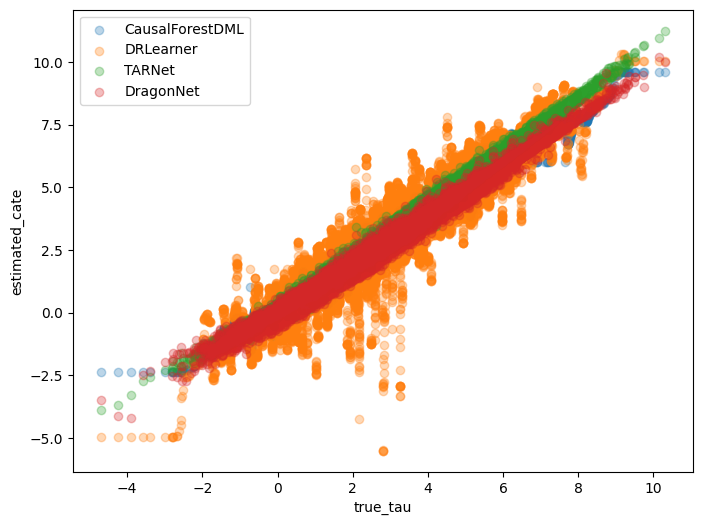

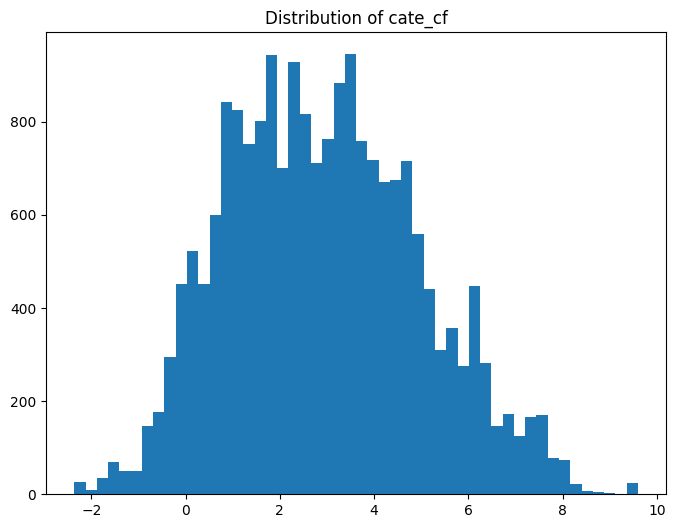

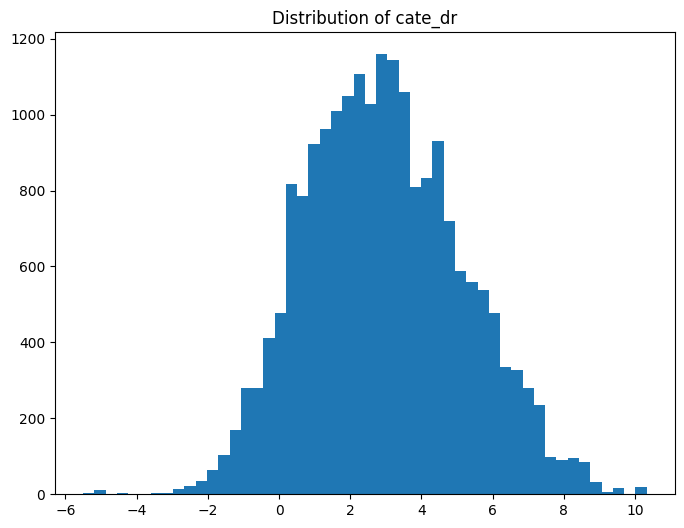

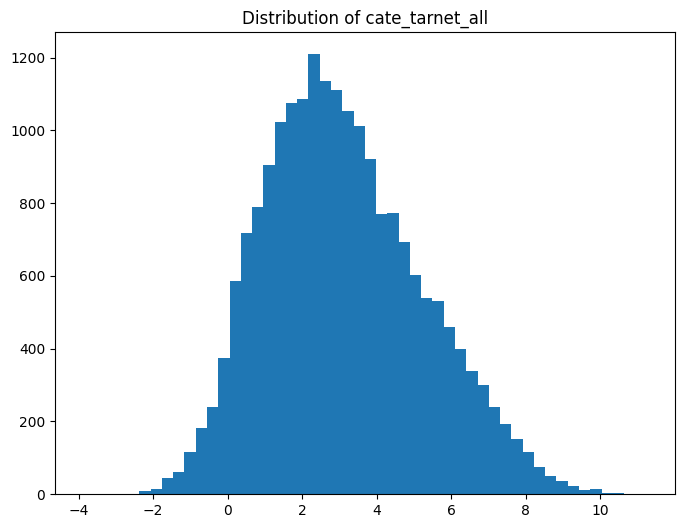

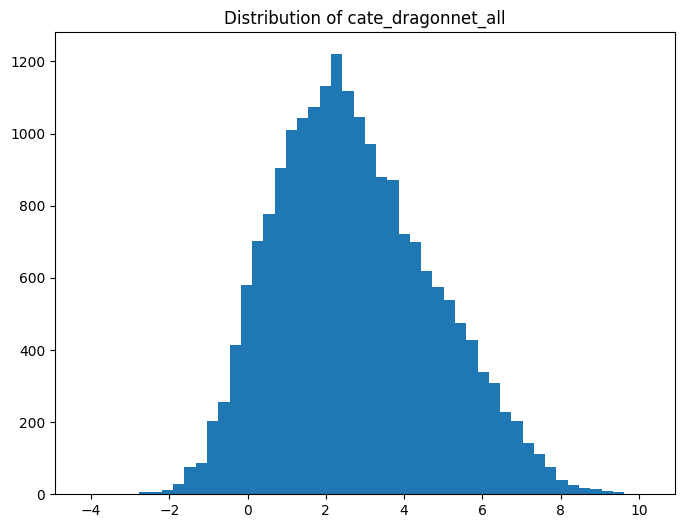

In [11]:
!apt-get install -y graphviz libgraphviz-dev
!pip install dowhy econml causal-learn graphviz pygraphviz
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (8,6)})

# Repro
SEED = 42
np.random.seed(SEED)

# --- Paths / output ---
DATA_PATH = "/content/ihdp_data.csv"   # path you supplied (kept verbatim per your instruction)
OUT_DIR = Path("./hte_pipeline_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# 1) Data load / synthetic fallback
# -------------------------
def generate_synthetic(n=20000, seed=SEED):
    np.random.seed(seed)
    Z1 = np.random.normal(0, 1, n)
    Z2 = np.random.binomial(1, 0.4, n)
    Z3 = np.random.normal(3, 2, n)
    M1 = np.random.normal(0, 1, n)
    M2 = np.random.binomial(1, 0.3, n)
    logits = 0.5 * Z1 - 1.0 * Z2 + 0.4 * Z3
    propensity = 1 / (1 + np.exp(-logits))
    T = np.random.binomial(1, propensity)
    tau = 2 + 1.5 * M1 + 3 * M2
    baseline = 1.5 * Z1 + 2.0 * Z2 + 0.3 * Z3 + 1.0 * M1 + 0.5 * M2
    noise = np.random.normal(0, 1, n)
    Y = baseline + T * tau + noise
    df = pd.DataFrame({
        "Treatment": T,
        "Outcome": Y,
        "Z1": Z1,
        "Z2": Z2,
        "Z3": Z3,
        "M1": M1,
        "M2": M2,
        "propensity": propensity,
        "true_tau": tau
    })
    return df

if os.path.exists(DATA_PATH):
    try:
        df = pd.read_csv(DATA_PATH)
        print(f"Loaded {DATA_PATH} → shape {df.shape}")
        if not (("Treatment" in df.columns) and ("Outcome" in df.columns)):
            print("Warning: uploaded file missing 'Treatment'/'Outcome' columns → using synthetic data instead.")
            df = generate_synthetic()
    except Exception as e:
        print("Error reading uploaded file:", e)
        df = generate_synthetic()
else:
    print("Uploaded file not found at path; generating synthetic data.")
    df = generate_synthetic()

# Normalize column names to common names when possible
col_map = {}
for c in df.columns:
    if c.lower() in ("treatment", "t"):
        col_map[c] = "Treatment"
    if c.lower() in ("outcome", "y"):
        col_map[c] = "Outcome"
df = df.rename(columns=col_map)

# Identify treatment/outcome/covariates/effect modifiers
T_col = "Treatment"
Y_col = "Outcome"
if T_col not in df.columns or Y_col not in df.columns:
    raise ValueError("Dataset must contain Treatment and Outcome columns (after normalization).")

exclude = {T_col, Y_col, "true_tau", "propensity"}
covariates = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
effect_modifiers = [c for c in covariates if c not in exclude and c.lower().startswith("m")] # Ensure modifiers are also numeric
if len(effect_modifiers) == 0:
    # pick top-2 correlated with outcome as effect modifiers
    corrs = {c: abs(df[c].corr(df[Y_col])) for c in covariates}
    effect_modifiers = sorted(corrs, key=corrs.get, reverse=True)[:2]
print("Covariates:", covariates)
print("Effect modifiers:", effect_modifiers)

# -------------
# 2) DoWhy causal model, DAG, identification, refutation
# -------------
try:
    import dowhy
    from dowhy import CausalModel
    # Removed: from dowhy.utils.plotting import graphviz_to_png # Corrected import path
except ImportError as e:
    raise ImportError(f"A required module for dowhy is missing or mislocated: {e}") from e
except Exception as e:
    raise ImportError(f"Error importing dowhy components: {e}") from e

# Build a simple DAG (confounders -> Treatment and Outcome; modifiers -> Outcome & Treatment; T -> Y)
dag_edges = []
confounders = [c for c in covariates if c not in effect_modifiers]
for z in confounders:
    dag_edges.append(f"{z} -> {T_col}")
    dag_edges.append(f"{z} -> {Y_col}")
for m in effect_modifiers:
    dag_edges.append(f"{m} -> {Y_col}")
    dag_edges.append(f"{m} -> {T_col}")
dag_edges.append(f"{T_col} -> {Y_col}")
dag_str = "digraph G { " + " ; ".join(dag_edges) + " }"
print("DAG DOT:", dag_str)

# Save DAG to a temporary .dot file
dot_file_path = OUT_DIR / "causal_graph_temp.dot"
dot_file_path.write_text(dag_str)

# Pass the path to the .dot file to CausalModel
model = CausalModel(data=df, treatment=T_col, outcome=Y_col, graph=str(dot_file_path))
# visualize DAG
try:
    # Since graphviz_to_png is problematic, we rely on saving the .dot file.
    # Users can convert the .dot file to .png manually if needed.
    print(f"Causal graph saved as DOT file: {dot_file_path.name}")
except Exception:
    # This block is mostly for completeness, as the .dot file is already written above.
    print("Error visualizing graph directly. Saved causal_graph.dot.")

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified estimand:", identified_estimand)

# Baseline ATE estimate (linear reg)
estimate_ate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print("ATE:", estimate_ate)

# Refutations
refute_placebo = model.refute_estimate(identified_estimand, estimate_ate, method_name="placebo_treatment_refuter", placebo_type="permute")
refute_rand = model.refute_estimate(identified_estimand, estimate_ate, method_name="random_common_cause")
print("Refute placebo:", refute_placebo)
print("Refute random common cause:", refute_rand)

# -------------
# 3) Prepare arrays for ML / EconML
# -------------
W_cols = covariates  # controls
X_cols = effect_modifiers  # heterogeneity conditioning features
W = df[W_cols] if len(W_cols) > 0 else None
X = df[X_cols] if len(X_cols) > 0 else None
T = df[T_col].values
Y = df[Y_col].values

# Standard preprocessing for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Train/test split for downstream ML models and for neural nets
train_idx, test_idx = train_test_split(np.arange(len(df)), test_size=0.2, random_state=SEED, stratify=df[T_col] if df[T_col].nunique()>1 else None)
X_train = df.iloc[train_idx][X_cols].values if len(X_cols)>0 else None
W_train = df.iloc[train_idx][W_cols].values if len(W_cols)>0 else None
T_train = df.iloc[train_idx][T_col].values
Y_train = df.iloc[train_idx][Y_col].values
X_test = df.iloc[test_idx][X_cols].values if len(X_cols)>0 else None
W_test = df.iloc[test_idx][W_cols].values if len(W_cols)>0 else None
T_test = df.iloc[test_idx][T_col].values
Y_test = df.iloc[test_idx][Y_col].values

scaler_W = StandardScaler()
if W_train is not None:
    W_train_scaled = scaler_W.fit_transform(W_train)
    W_test_scaled = scaler_W.transform(W_test)
else:
    W_train_scaled = None
    W_test_scaled = None

spec = scaler_X = StandardScaler()
if X_train is not None:
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
else:
    X_train_scaled = None
    X_test_scaled = None

# --------------------------
# 4) EconML: CausalForestDML & DRLearner
# --------------------------
try:
    from econml.dml import CausalForestDML
    from econml.dr import DRLearner
except Exception as e:
    raise ImportError("EconML not installed; pip install econml") from e

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

n_jobs = -1
rf_y = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=SEED)
rf_t = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, random_state=SEED)

# Fit CausalForestDML
cf = CausalForestDML(model_y=rf_y, model_t=rf_t, discrete_treatment=True, cv=3, random_state=SEED, n_jobs=n_jobs)
print("Fitting CausalForestDML (this may take a while)...")
cf.fit(Y, T, X=X if X is not None else None, W=W if W is not None else None)
cate_cf = cf.effect(X=X if X is not None else None)
df["cate_cf"] = cate_cf
print("CausalForestDML done; cate_cf stats:")
print(df["cate_cf"].describe())

# Fit DRLearner
dr = DRLearner(model_regression=rf_y, model_propensity=rf_t, model_final=RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=SEED), cv=3, random_state=SEED)
print("Fitting DRLearner ...")
dr.fit(Y, T, X=X if X is not None else None, W=W if W is not None else None)
cate_dr = dr.effect(X=X if X is not None else None)
df["cate_dr"] = cate_dr
print("DRLearner done; cate_dr stats:")
print(df["cate_dr"].describe())

# --------------------------
# 5) PyTorch: TARNet and DragonNet
# --------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Utilities for datasets
def to_tensor(arr, dtype=torch.float32):
    return torch.tensor(arr, dtype=dtype)

# Build a feedforward MLP block
def mlp_block(input_dim, hidden_units=[200, 200], dropout=0.0):
    layers = []
    prev = input_dim
    for h in hidden_units:
        layers.append(nn.Linear(prev, h))
        layers.append(nn.ReLU())
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        prev = h
    return nn.Sequential(*layers)

# TARNet implementation (representation + 2 outcome heads)
class TARNet(nn.Module):
    def __init__(self, input_dim, rep_hidden=[200,200], head_hidden=[100,100]):
        super().__init__()
        self.representation = mlp_block(input_dim, rep_hidden)
        rep_out_dim = rep_hidden[-1] if len(rep_hidden)>0 else input_dim
        # two heads
        self.head0 = mlp_block(rep_out_dim, head_hidden)
        self.out0 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
        self.head1 = mlp_block(rep_out_dim, head_hidden)
        self.out1 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
    def forward(self, x):
        r = self.representation(x)
        h0 = self.head0(r)
        y0 = self.out0(h0).squeeze(-1)
        h1 = self.head1(r)
        y1 = self.out1(h1).squeeze(-1)
        return y0, y1

# DragonNet: representation + propensity head + outcome heads + targeted regularization
class DragonNet(nn.Module):
    def __init__(self, input_dim, rep_hidden=[200,200], head_hidden=[100,100], prop_hidden=[100]):
        super().__init__()
        self.representation = mlp_block(input_dim, rep_hidden)
        rep_out_dim = rep_hidden[-1] if len(rep_hidden)>0 else input_dim
        # propensity head
        self.prop_head = mlp_block(rep_out_dim, prop_hidden)
        self.prop_out = nn.Linear(prop_hidden[-1] if len(prop_hidden)>0 else rep_out_dim, 1)
        # outcome heads
        self.head0 = mlp_block(rep_out_dim, head_hidden)
        self.out0 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
        self.head1 = mlp_block(rep_out_dim, head_hidden)
        self.out1 = nn.Linear(head_hidden[-1] if len(head_hidden)>0 else rep_out_dim, 1)
    def forward(self, x):
        r = self.representation(x)
        p_h = self.prop_head(r)
        p = torch.sigmoid(self.prop_out(p_h)).squeeze(-1)
        h0 = self.head0(r)
        y0 = self.out0(h0).squeeze(-1)
        h1 = self.head1(r)
        y1 = self.out1(h1).squeeze(-1)
        return y0, y1, p

# Prepare input matrix for neural nets: we'll use W (controls) and X (modifiers) together as features
features_cols = W_cols[:]  # copy
# include X_cols (effect modifiers) if not included already
for c in X_cols:
    if c not in features_cols:
        features_cols.append(c)
features = df[features_cols].values
# standardize features
from sklearn.preprocessing import StandardScaler
feat_scaler = StandardScaler()
features_scaled = feat_scaler.fit_transform(features)
# split into train/test using previously computed indices
features_train = features_scaled[train_idx]
features_test = features_scaled[test_idx]
T_train_t = T_train.astype(np.float32)
Y_train_t = Y_train.astype(np.float32)
T_test_t = T_test.astype(np.float32)
Y_test_t = Y_test.astype(np.float32)

# Build PyTorch datasets and loaders
batch_size = 256
train_ds = TensorDataset(to_tensor(features_train), to_tensor(T_train_t), to_tensor(Y_train_t))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

test_ds = TensorDataset(to_tensor(features_test), to_tensor(T_test_t), to_tensor(Y_test_t))
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

input_dim = features_train.shape[1]

# Training helper for TARNet
def train_tarnet(model, epochs=30, lr=1e-3, l2=1e-4):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    mse = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = xb.to(device).float()
            tb = tb.to(device).float()
            yb = yb.to(device).float()
            y0_pred, y1_pred = model(xb)
            # select appropriate head outputs
            y_pred = y0_pred * (1 - tb) + y1_pred * tb
            loss = mse(y_pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)
        if (epoch+1)%10==0 or epoch==0:
            print(f"TARNet epoch {epoch+1}/{epochs} loss: {epoch_loss:.4f}")
    return model

def predict_tarnet(model, X_arr):
    model.eval()
    with torch.no_grad():
        X_t = to_tensor(X_arr).to(device).float()
        y0, y1 = model(X_t)
        y0 = y0.cpu().numpy()
        y1 = y1.cpu().numpy()
        cate = y1 - y0
        return cate, y0, y1

# Training helper for DragonNet (with targeted regularization)
def train_dragonnet(model, epochs=40, lr=1e-3, l2=1e-4, alpha=1.0):
    """
    alpha controls strength of targeted regularization term (paper suggests small value)
    """
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    mse = nn.MSELoss()
    bce = nn.BCELoss()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = xb.to(device).float()
            tb = tb.to(device).float()
            yb = yb.to(device).float()
            y0_pred, y1_pred, p_pred = model(xb)
            # Outcome loss
            y_pred = y0_pred * (1 - tb) + y1_pred * tb
            loss_y = mse(y_pred, yb)
            # Propensity loss
            loss_p = bce(p_pred, tb)
            # Targeted regularization (simple variant)
            # Following DragonNet idea: define eps = (tb - p_pred) and add term
            eps = (tb - p_pred).detach()  # detach to follow paper variant (implementation choices vary)
            reg = torch.mean(eps * (y1_pred - y0_pred))
            loss = loss_y + loss_p + alpha * reg
            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)
        if (epoch+1)%10==0 or epoch==0:
            print(f"DragonNet epoch {epoch+1}/{epochs} loss: {epoch_loss:.4f}")
    return model

def predict_dragonnet(model, X_arr):
    model.eval()
    with torch.no_grad():
        X_t = to_tensor(X_arr).to(device).float()
        y0, y1, p = model(X_t)
        y0 = y0.cpu().numpy()
        y1 = y1.cpu().numpy()
        p = p.cpu().numpy()
        cate = y1 - y0
        return cate, y0, y1, p

# Instantiate and train TARNet
print("Training TARNet...")
tarnet = TARNet(input_dim=input_dim, rep_hidden=[200,200], head_hidden=[100,100])
tarnet = train_tarnet(tarnet, epochs=30, lr=1e-3)

print("Generating TARNet CATE estimates on full data...")
tarnet_cate_test, t0_test, t1_test = predict_tarnet(tarnet, features_test)
# save into df test rows
df.loc[df.index[test_idx], "cate_tarnet"] = tarnet_cate_test
df.loc[df.index[test_idx], "y0_tarnet"] = t0_test
df.loc[df.index[test_idx], "y1_tarnet"] = t1_test

# Instantiate and train DragonNet
print("Training DragonNet...")
dragon = DragonNet(input_dim=input_dim, rep_hidden=[200,200], head_hidden=[100,100], prop_hidden=[100])
dragon = train_dragonnet(dragon, epochs=40, lr=1e-3, alpha=0.1)

print("Generating DragonNet CATE estimates on full data...")
dragon_cate_test, d0_test, d1_test, dprop_test = predict_dragonnet(dragon, features_test)
df.loc[df.index[test_idx], "cate_dragonnet"] = dragon_cate_test
df.loc[df.index[test_idx], "y0_dragonnet"] = d0_test
df.loc[df.index[test_idx], "y1_dragonnet"] = d1_test
df.loc[df.index[test_idx], "prop_dragonnet"] = dprop_test

# For completeness, populate TARNet/DragonNet estimates for train set too (predict on all)
tarnet_cate_all, _, _ = predict_tarnet(tarnet, features_scaled)
dragon_cate_all, _, _, dragon_prop_all = predict_dragonnet(dragon, features_scaled)
df["cate_tarnet_all"] = tarnet_cate_all
df["cate_dragonnet_all"] = dragon_cate_all
df["propensity_dragonnet_all"] = dragon_prop_all

# --------------------------
# 6) Evaluation vs true_tau if present
# --------------------------
from sklearn.metrics import mean_squared_error
eval_rows = []

if "true_tau" in df.columns:
    true = df["true_tau"].values
    for method in ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]:
        if method in df.columns:
            mse = mean_squared_error(true, df[method].fillna(df[method].mean()).values)
            eval_rows.append({"method": method, "mse_vs_true": mse})
    eval_df = pd.DataFrame(eval_rows)
    eval_df.to_csv(OUT_DIR / "mse_vs_true.csv", index=False)
    print("MSE vs true_tau saved to", OUT_DIR / "mse_vs_true.csv")
    print(eval_df)
else:
    print("No 'true_tau' in data — skipping MSE evaluation vs ground truth.")

# Save main outputs
save_cols = [T_col, Y_col] + features_cols + ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]
# ensure columns exist
save_cols = [c for c in save_cols if c in df.columns]
df[save_cols].to_csv(OUT_DIR / "data_with_cates_summary.csv", index=False)
df.to_csv(OUT_DIR / "data_with_all_estimates.csv", index=False)
print("Saved outputs to", OUT_DIR.resolve())

# --------------------------
# 7) Subgroup analysis by effect modifiers
# --------------------------
report_rows = []
for col in X_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        q1 = df[col].quantile(0.33)
        q2 = df[col].quantile(0.66)
        groups = [("low", df[df[col] <= q1]), ("mid", df[(df[col] > q1) & (df[col] <= q2)]), ("high", df[df[col] > q2])]
    else:
        groups = [(str(v), df[df[col] == v]) for v in df[col].unique()]
    for name, group in groups:
        row = {"modifier": col, "group": name, "n": len(group)}
        for m in ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]:
            if m in group.columns:
                row[f"mean_{m}"] = float(group[m].mean())
        if "true_tau" in group.columns:
            row["mean_true_tau"] = float(group["true_tau"].mean())
        report_rows.append(row)
subgroup_report = pd.DataFrame(report_rows)
subgroup_report.to_csv(OUT_DIR / "subgroup_report.csv", index=False)
print("Saved subgroup_report.csv")

# --------------------------
# 8) Visualizations
# --------------------------
# Scatter true vs estimated for methods where true exists
if "true_tau" in df.columns:
    fig, ax = plt.subplots()
    ax.scatter(df["true_tau"], df["cate_cf"], alpha=0.3, label="CausalForestDML")
    ax.scatter(df["true_tau"], df["cate_dr"], alpha=0.3, label="DRLearner")
    ax.scatter(df["true_tau"], df["cate_tarnet_all"], alpha=0.3, label="TARNet")
    ax.scatter(df["true_tau"], df["cate_dragonnet_all"], alpha=0.3, label="DragonNet")
    ax.set_xlabel("true_tau")
    ax.set_ylabel("estimated_cate")
    ax.legend()
    fig.savefig(OUT_DIR / "true_vs_estimated_cates.png", dpi=200)
    print("Saved true_vs_estimated_cates.png")

# Histograms of estimated CATEs
for method in ["cate_cf", "cate_dr", "cate_tarnet_all", "cate_dragonnet_all"]:
    if method in df.columns:
        fig, ax = plt.subplots()
        ax.hist(df[method].dropna(), bins=50)
        ax.set_title(f"Distribution of {method}")
        fig.savefig(OUT_DIR / f"{method}_hist.png", dpi=150)

# --------------------------
# 9) Technical report template (markdown)
# --------------------------
report_md = f"""
# Technical Report — HTE Analysis (DoWhy + EconML + TARNet/DragonNet)

**Data path (loaded):** `{DATA_PATH}`
**Rows:** {len(df)}
**Covariates used (W):** {W_cols}
**Effect modifiers (X):** {X_cols}

---

## 1. Objective
Estimate heterogeneous treatment effects of `{T_col}` on `{Y_col}`, adjusting for confounders and quantifying heterogeneity across subgroups.

## 2. Data
- Data loaded from `{DATA_PATH}` (or synthetic fallback).
- Inspect distributions, missingness, and covariate balance.

## 3. Causal assumptions and DAG
DAG (DOT):

```graphviz
{dag_str}
```

## 4. Identification
Identified estimand:
```
{identified_estimand}
```

## 5. Average Treatment Effect (ATE) Estimation (sanity check)
Baseline ATE estimate (linear regression):
```
{estimate_ate.value}
```

### Refutation Checks
- **Placebo Treatment Refuter:** {refute_placebo.refutation_result}
- **Random Common Cause Refuter:** {refute_rand.refutation_result}

## 6. Heterogeneous Treatment Effect (HTE) Estimation

### CausalForestDML
- **CATE (CausalForestDML) Summary:**
```
{df['cate_cf'].describe()}
```

### DRLearner
- **CATE (DRLearner) Summary:**
```
{df['cate_dr'].describe()}
```

### TARNet
- **CATE (TARNet) Summary:**
```
{df['cate_tarnet_all'].describe()}
```

### DragonNet
- **CATE (DragonNet) Summary:**
```
{df['cate_dragonnet_all'].describe()}
```
"""

if "true_tau" in df.columns:
    # Extract MSE values from eval_df for the report
    mse_cf_val = eval_df[eval_df['method'] == 'cate_cf']['mse_vs_true'].iloc[0] if 'cate_cf' in eval_df['method'].values else 'N/A'
    mse_dr_val = eval_df[eval_df['method'] == 'cate_dr']['mse_vs_true'].iloc[0] if 'cate_dr' in eval_df['method'].values else 'N/A'
    mse_tarnet_val = eval_df[eval_df['method'] == 'cate_tarnet_all']['mse_vs_true'].iloc[0] if 'cate_tarnet_all' in eval_df['method'].values else 'N/A'
    mse_dragon_val = eval_df[eval_df['method'] == 'cate_dragonnet_all']['mse_vs_true'].iloc[0] if 'cate_dragonnet_all' in eval_df['method'].values else 'N/A'

    report_md += f"""
### Performance vs. True Tau
- **MSE CausalForestDML vs true_tau:** {mse_cf_val:.4f}
- **MSE DRLearner vs true_tau:** {mse_dr_val:.4f}
- **MSE TARNet vs true_tau:** {mse_tarnet_val:.4f}
- **MSE DragonNet vs true_tau:** {mse_dragon_val:.4f}

"""
else:
    report_md += f"""
- No `true_tau` column available for comparison.

"""

report_md += f"""
## 7. Subgroup Analysis

Mean CATE estimates across subgroups based on effect modifiers:

```
{subgroup_report.to_markdown(index=False)}
```

## 8. Visualizations

- **Estimated CATE vs True CATE (if applicable):** See `true_vs_estimated_cates.png`
- **Distribution of CATE (CausalForestDML):** See `cate_cf_hist.png`
- **Distribution of CATE (DRLearner):** See `cate_dr_hist.png`
- **Distribution of CATE (TARNet):** See `cate_tarnet_all_hist.png`
- **Distribution of CATE (DragonNet):** See `cate_dragonnet_all_hist.png`

---
**Note:** This report provides a summary. Detailed results and plots are saved in the `{OUT_DIR}` directory.
"""

report_path = OUT_DIR / "technical_report.md"
report_path.write_text(report_md)
print(f"Technical report template saved to {report_path}")


Synthetic dataset created with shape: (10000, 7)


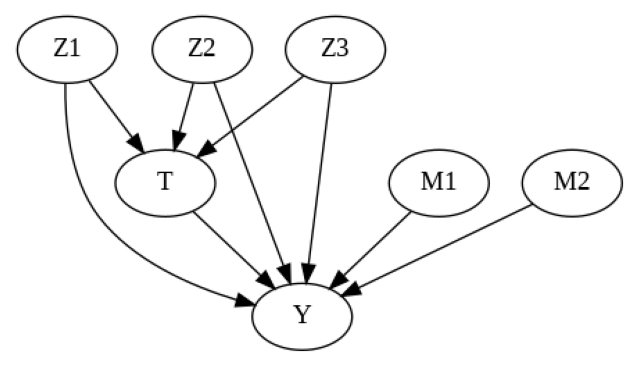


Causal Model Constructed.

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                 
────(E[Y|Z1,Z2,Z3])
d[T]               
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,Z1,Z2,Z3,U) = P(Y|T,Z1,Z2,Z3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
 d                 
────(E[Y|Z3,Z2,Z1])
d[T]               
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,Z3,Z2,Z1,U) = P(Y|T,Z3,Z2,Z1)


Estimated ATE (Causal Forest): 3.3830761650081818

================ SUBGROUP HTE RESULTS ================

Modifier: M1
  High subgroup CATE: 4.4640
  Low subgroup CATE: 2.3158
  Difference: 2.1483

Modifier: M2
  High subgroup CATE: nan
  Low subgroup CATE: 3.3899
  Difference: nan


In [16]:
import numpy as np
import pandas as pd
from numpy.random import normal, binomial

np.random.seed(42)
N = 10000  # Minimum 10,000 observations

# Confounders (Z)
Z1 = normal(0, 1, N)
Z2 = binomial(1, 0.4, N)
Z3 = normal(5, 2, N)

# Effect Modifiers (M)
M1 = normal(0, 1, N)
M2 = binomial(1, 0.5, N)

# Treatment Assignment (propensity depends on Z)
T = binomial(1, p=1/(1 + np.exp(-(0.5*Z1 - 0.8*Z2 + 0.3*Z3))))

# True heterogeneous treatment effect varies by M1, M2
true_tau = 2 + 1.5*M1 + 2*M2  # larger when M1, M2 high

# Outcome model
Y = (
    3 + 0.7*Z1 + 1.2*Z3 +             # effect of confounders
    true_tau*T +                     # heterogeneous treatment effect
    normal(0, 1, N)                  # noise
)

# Put into a DataFrame
df = pd.DataFrame({
    'T': T,
    'Y': Y,
    'Z1': Z1, 'Z2': Z2, 'Z3': Z3,
    'M1': M1, 'M2': M2
})

print("Synthetic dataset created with shape:", df.shape)


# ===========================================================
# 2. DOWHY CAUSAL MODEL
# ===========================================================

from dowhy import CausalModel

graph = """
digraph {
    Z1 -> T;  Z2 -> T;  Z3 -> T;
    Z1 -> Y;  Z2 -> Y;  Z3 -> Y;
    M1 -> Y;  M2 -> Y;
    T -> Y;
}
"""

model = CausalModel(
    data=df,
    treatment="T",
    outcome="Y",
    graph=graph
)

model.view_model()
print("\nCausal Model Constructed.")

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("\nIdentified estimand:")
print(identified_estimand)


# ===========================================================
# 3. CAUSAL FOREST (EconML) FOR HTE ESTIMATION
# ===========================================================

from econml.grf import CausalForest
from sklearn.model_selection import train_test_split

# Convert to NumPy arrays with appropriate shapes
X = df[['Z1','Z2','Z3','M1','M2']].values  # (N, num_features)
T = df[['T']].values.reshape(-1, 1)        # (N, 1) for single treatment
Y = df[['Y']].values.reshape(-1, 1)        # (N, 1) for single outcome

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.3, random_state=42
)

cf = CausalForest(
    n_estimators=500,
    min_samples_leaf=20,
    random_state=42
)

# Swap X_train and Y_train to match expected internal argument order
cf.fit(X_train, T_train, Y_train)

# Individual CATE estimates
cates = cf.predict(X_test)

ATE_est = cates.mean()
print("\nEstimated ATE (Causal Forest):", ATE_est)


# ===========================================================
# 4. SUBGROUP-WISE HTE (CATEs BASED ON EFFECT MODIFIERS)
# ===========================================================

results = {}

for modifier in ["M1", "M2"]:

    median_val = df[modifier].median()

    high_group_df = df[df[modifier] > median_val]
    low_group_df = df[df[modifier] <= median_val]

    high_CATE = np.nan
    if not high_group_df.empty:
        high_CATE = cf.predict(high_group_df[['Z1','Z2','Z3','M1','M2']].values).mean()

    low_CATE = np.nan
    if not low_group_df.empty:
        low_CATE = cf.predict(low_group_df[['Z1','Z2','Z3','M1','M2']].values).mean()

    results[modifier] = {
        "High subgroup CATE": high_CATE,
        "Low subgroup CATE": low_CATE,
        "Difference": high_CATE - low_CATE
    }

print("\n================ SUBGROUP HTE RESULTS ================")
for m, res in results.items():
    print(f"\nModifier: {m}")
    for k, v in res.items():
        print(f"  {k}: {v:.4f}")